# **Convolutional Neural Networks**

# **Convolution**
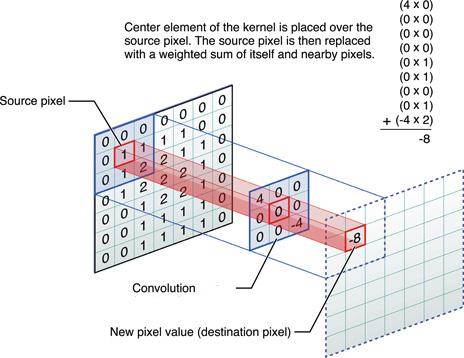

## **The Convolutional Layer**

* Convolution operate over 3D tensors, called *feature maps*, with two spatial axes (**height** and **width**) as well as a depth axis (also called the **channels** axis)

* For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue

* For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray)

* The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map

* This output feature map is still a 3D tensor: it has a width and a height
  * Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data




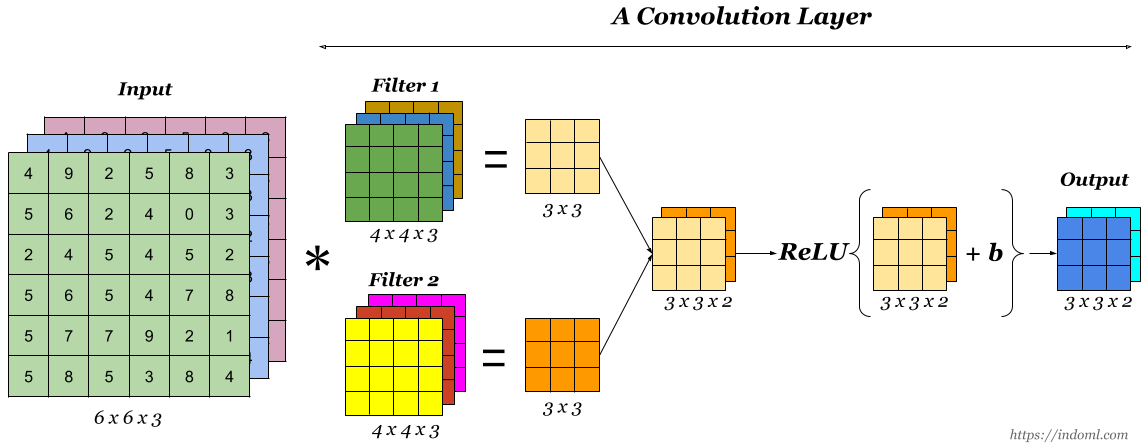



---



* This output feature map is still a 3D tensor: it has a width and a height
  * Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data

  * The output width and height may differ from the input width and height
  
    * They may differ for two reasons:
      * Border effects, which can be countered by padding the input feature map
      * The use of stride that controls how the filter convolved around the input volume



* **Padding** consists of adding an appropriate number of rows and columns on each side of the input feature map

  * In Conv2D layers, padding is configurable via the padding argument, which takes two values: "valid", which means no padding (only valid window locations will be used) and "same", which means “pad in such a way as to have an output with the same width and height as the input.” The padding argument defaults to "valid"

* So, to compute output width and height we can use this formula:

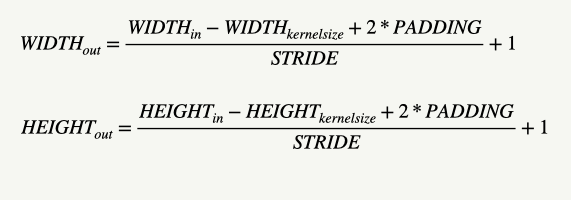

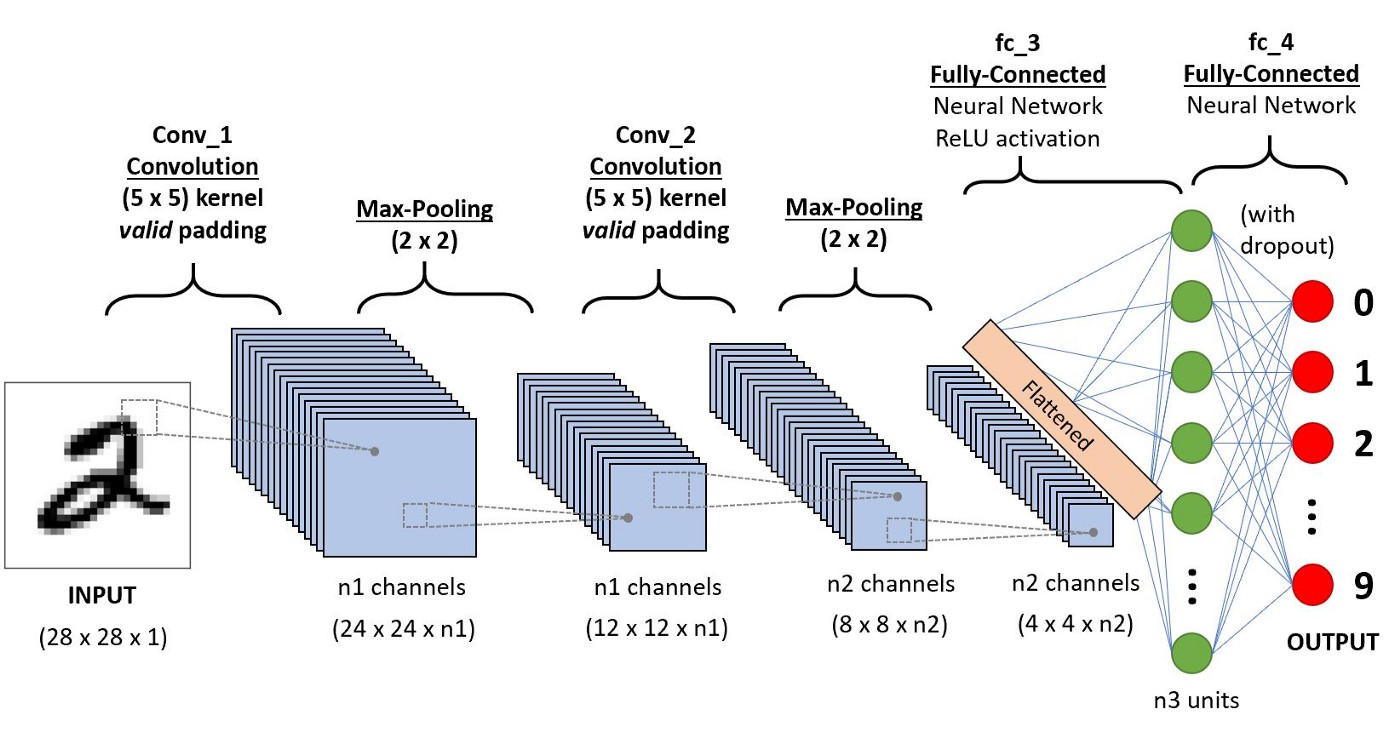

## **Flowers Classification**



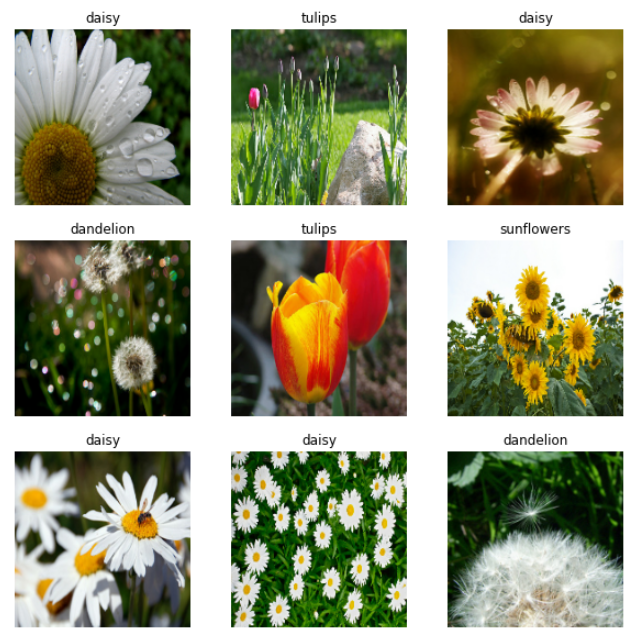

* Now, we build a Convolutional Neural Network to classify images of flowers

* We use a dataset that contains 3670 photos of flowers

* The dataset contains 5 sub-directories, one per class

In [ ]:
import tensorflow as tf
import pathlib

import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


* The dataset contains photos of roses, tulips, daisy, dandelion and sunflowers

In [ ]:
paths = list(data_dir.glob('*'))
paths 

[PosixPath('/root/.keras/datasets/flower_photos/roses'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion'),
 PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt'),
 PosixPath('/root/.keras/datasets/flower_photos/sunflowers')]

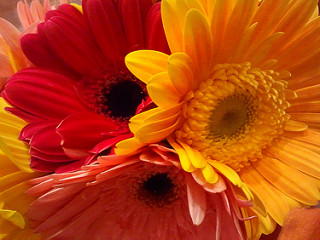

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

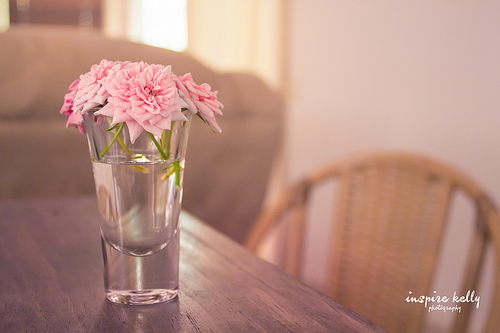

In [ ]:
PIL.Image.open(str(roses[1]))

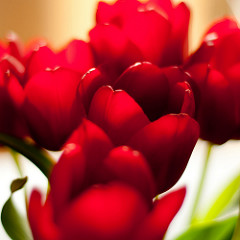

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

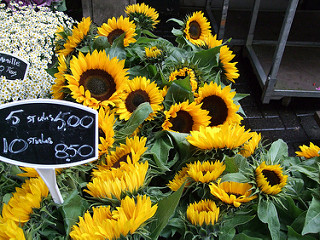

In [ ]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

* Let's load these images off disk using *image_dataset_from_directory* utility

* This will take you from a directory of images on disk to a *tensorflow.data.Dataset*

* Now, we define some parameters for the loader

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset = 'training', seed = 42,
    image_size = (img_height, img_width), batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
train_set

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
val_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, validation_split = 0.2, subset = 'validation', seed = 42,
  image_size = (img_height, img_width), batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_set.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

* We visualize the first 9 images from the training set

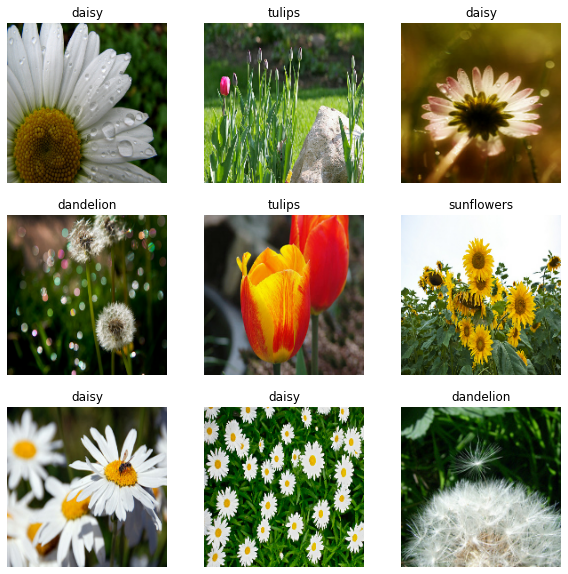

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


* We can see that the *image_batch* is a tensor of the shape (32, 180, 180, 3)

* This is a batch of 32 images of shape 180x180x3
  * The last dimension referes to color channels RGB

* The *label_batch* is a tensor of the shape (32,): these are corresponding labels to the 32 images

* The RGB channel values are in the [0, 255] range

* This is not ideal for a neural network

* We will standardize values to be in the [0, 1] range

In [ ]:
import numpy as np

In [ ]:
for image_batch, labels_batch in train_set:
  print('Min value: ', np.min(image_batch))
  print('Max value: ', np.max(image_batch))
  break

Min value:  0.0
Max value:  255.0


* We can use a Rescaling layer

In [ ]:
norm_layer = layers.experimental.preprocessing.Rescaling(1. / 255.)

In [ ]:
norm_train_set = train_set.map(lambda x, y: (norm_layer(x), y))

In [ ]:
for image_batch, labels_batch in norm_train_set:
  print('Min value: ', np.min(image_batch))
  print('Max value: ', np.max(image_batch))
  break

Min value:  0.0
Max value:  1.0


* We can apply it to the dataset by calling map or 

* We can include the layer inside our model definition

* Now, we can build the model

* In particular, the model consists of three convolution blocks with a max pool layer in each of them

In [ ]:
num_classes = len(class_names)
num_classes

5

In [ ]:
model = Sequential()
model.add(layers.Input(shape=(img_height, img_width, 3)))
model.add(layers.experimental.preprocessing.Rescaling(1. / 255.))
model.add(layers.Conv2D(32, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 176, 176, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 128)       0

* We can see that the output of every Conv2D and MaxPooling2D layers is a 3D tensor of shape (height, width, channels)

* The *height* and *width* dimension tend to shrink as we go deeper in the network

* The number of output channels for each Conv2D layer is controlled by the first argument

* The *channels* dimension tend to increase as we go deeper in the network

* To complete our model, we will feed the last output tensor into one or more Dense layers to perform classification

* The Dense layers take a 1D tensor as input, while the current output is a 3D tensor

* So, we will flatten the 3D output to 1D

* Then, add one or more Dense layers on top

* This dataset has 5 output classes, so we use a final Dense layer with 5 outputs and a softmax activation

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(num_classes, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 176, 176, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 128)       0

In [ ]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])

In [ ]:
EPOCHS = 5
history = model.fit(train_set, validation_data = val_set, 
                    epochs = EPOCHS)

Epoch 1/5
92/92 [==============================] - 10s 99ms/step - loss: 1.1662 - accuracy: 0.5313 - val_loss: 1.0978 - val_accuracy: 0.5572
Epoch 2/5
92/92 [==============================] - 9s 98ms/step - loss: 0.9926 - accuracy: 0.6165 - val_loss: 1.0587 - val_accuracy: 0.6008
Epoch 3/5
92/92 [==============================] - 9s 99ms/step - loss: 0.8619 - accuracy: 0.6740 - val_loss: 1.0110 - val_accuracy: 0.6376
Epoch 4/5
92/92 [==============================] - 9s 98ms/step - loss: 0.6813 - accuracy: 0.7490 - val_loss: 1.1286 - val_accuracy: 0.6471
Epoch 5/5
92/92 [==============================] - 9s 98ms/step - loss: 0.5151 - accuracy: 0.8093 - val_loss: 1.1639 - val_accuracy: 0.6308


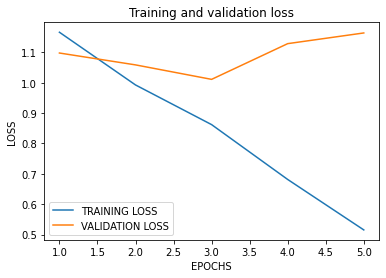

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label = 'TRAINING LOSS')
plt.plot(epochs, val_loss, label = 'VALIDATION LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title('Training and validation loss')
plt.legend()

plt.show()

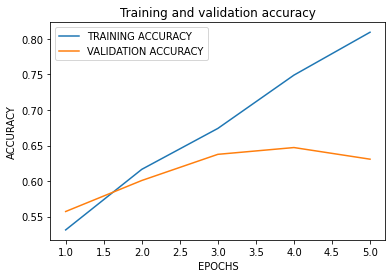

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, label='TRAINING ACCURACY')
plt.plot(epochs, val_acc, label = 'VALIDATION ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

tensorflow.python.framework.ops.EagerTensor

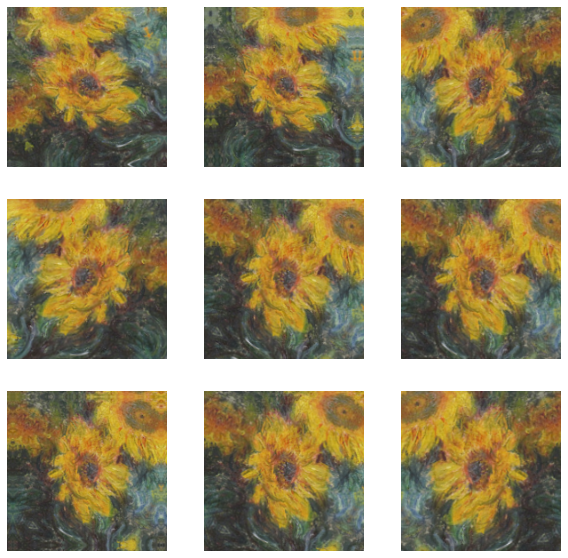

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_set,
  validation_data=val_set,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 10s 89ms/step - loss: 1.3691 - accuracy: 0.4104 - val_loss: 1.0835 - val_accuracy: 0.5613
Epoch 2/15
92/92 [==============================] - 8s 84ms/step - loss: 1.0438 - accuracy: 0.5797 - val_loss: 1.0247 - val_accuracy: 0.5913
Epoch 3/15
92/92 [==============================] - 8s 83ms/step - loss: 0.9529 - accuracy: 0.6138 - val_loss: 0.9645 - val_accuracy: 0.6213
Epoch 4/15
92/92 [==============================] - 8s 83ms/step - loss: 0.8988 - accuracy: 0.6485 - val_loss: 0.9253 - val_accuracy: 0.6512
Epoch 5/15
92/92 [==============================] - 8s 83ms/step - loss: 0.8259 - accuracy: 0.6703 - val_loss: 0.8126 - val_accuracy: 0.6826
Epoch 6/15
92/92 [==============================] - 8s 83ms/step - loss: 0.7712 - accuracy: 0.6993 - val_loss: 0.8426 - val_accuracy: 0.6907
Epoch 7/15
92/92 [==============================] - 8s 83ms/step - loss: 0.7372 - accuracy: 0.7170 - val_loss: 0.7632 - val_accuracy: 0.7044
Epoch 8/15
9

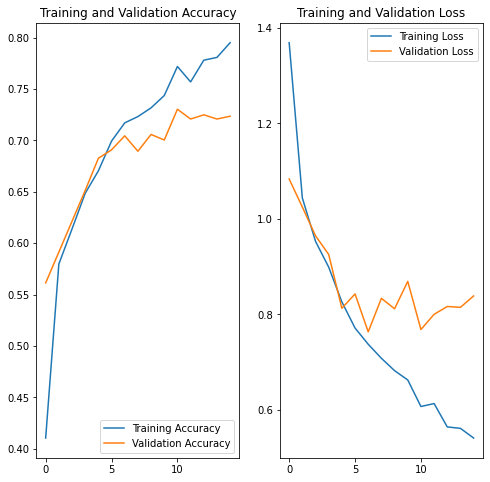

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0) # Create a batch

predictions = model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100*np.max(predictions))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 99.99 percent confidence.
